In [ ]:
pip install sbi


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53670 sha256=155fe8427ecd76f01e383f60264fa7c386b48068e1c739a375e510785cab552c
  Stored in directory: /root/.cache/pip/wheels/3b/88/52/cbd4ed0597b48916de3de19b28d7297c72595f56085068c772
Successfully built nflows


In [ ]:
import torch
from scipy import signal
from scipy import interpolate
from scipy import stats as st
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE
from sbi.inference.base import *
from ipywidgets import *
import pickle
import numpy as np
import pandas as pd
import random
import random as rd
import math
from matplotlib import pyplot as plt

In [ ]:
#Creates array of spike times according to poisson distribution of frequency Freq (Hz)
#Relevant if you wish to save a time series of random inputs to be used to compare across multiple sets of parameters
Tmax = 750;
dt = 0.1;
t = np.linspace(0,Tmax, int((Tmax)/dt) + 1);
Freq = 40;
tr = 1;
spk = np.zeros(len(t)) #make sure no issues from 1D array
tspk = []                                  # trials
r = Freq/(len(t))*Tmax/1000;          # [rate] = Spk/bin
#spk = double(rand(1,len(t)+1)<r);    # Generated spike trains
for i in range(len(t)):
    if(rd.uniform(0,1) < r):
        spk[i] = 1
#spk = spk[1:len(t)];                 #make sure list splicing is the same between languages
#tspk = find(spk.H > 0)*dt;                 # Spike times original line: tspk = find(spk'>0)*dt, what does spk' do? Is find the same in python? also same issue on line 57
for i in range(len(t)):
    if(spk[i]  > 0):
        tspk.append(round(i*dt,1))
ISI = np.diff(tspk);

In [ ]:
#Runge Kutta Order 2 solution to Depression/Facilitation ODE system.
  #spkse:
    #0 ~ Global Poisson Spike Train
    #1 ~ Periodic Inputs
    #2 ~ Poisson Inputs
    #3 ~ Poisson Inputs with minimum ISI
  #Gaussian White Noise Magnitude
  #fig
    #0 ~ No figures
    #1 ~ Trace and histograms
    #2 ~ Trace only
Tmax = 750
dt = 0.1;
t = np.linspace(0,Tmax, int((Tmax)/dt) + 1);

def gen_spikes(params, spkse, noise, fig):
    p0 = params[0]
    p1 = params[1]
    p2 = params[2]
    p3 = params[3]

    SPKSE = spkse;
    #             % 1: Uniform
    #             % 2: Poisson
    #             % 3: Poisson (ISI>ISI_min)


    Tmax = 750;
    dt = 0.1;
    t = np.linspace(0,Tmax, int((Tmax)/dt)+1);



    # Input spike times
    if(SPKSE == 0):
      global spk
      global tspk
      global ISI
    if (SPKSE == 1):
        Freq = 20;
        ISI = 1000/Freq;
        tspk = np.linspace(ISI,Tmax, int((Tmax-ISI)/ISI)+1);
        spk = np.zeros(len(t));

        for item in tspk:
            spk[int(item)*10]=1;

    elif (SPKSE == 2):
        Freq = 40;
        tr = 1;
        spk = np.zeros(len(t)) #make sure no issues from 1D array
        tspk = []                                  # trials
        r = Freq/(len(t))*Tmax/1000;          # [rate] = Spk/bin
        #spk = double(rand(1,len(t)+1)<r);    # Generated spike trains
        for i in range(len(t)):
            if(rd.uniform(0,1) < r):
                spk[i] = 1
        #spk = spk[1:len(t)];                 #make sure list splicing is the same between languages
        #tspk = find(spk.H > 0)*dt;                 # Spike times original line: tspk = find(spk'>0)*dt, what does spk' do? Is find the same in python? also same issue on line 57
        for i in range(len(t)):
            if(spk[i]  > 0):
                tspk.append(round(i*dt,1))
        ISI = np.diff(tspk);

    elif (SPKSE == 3):
        spk = np.zeros(len(t))
        tspkbase = []
        ISImin = 5;
        Freq = 40;
        tr = 1;                                # % trials
        r = Freq/(len(t)-1)*Tmax/1000;       #% [rate] = Spk/bin
        #spk = double(rand(1,len(t)+1)<r);

        for i in range(len(t)):
            if(rd.uniform(0,1) < r):
                spk[i] = 1
        #spk = spk[1:len(t)]; #is this still needed, how to we make sure indices are consistent since python starts at )?
        #tspkbase = find(spk>0)*dt;
                    #% Spike times## what is find in python?
        for i in range(len(t)):
            if(spk[i]  > 0):
                tspkbase.append(round(i*dt,1))

        ISIbase = np.diff(tspkbase);   #same with diff?
        ISI = [];
        i=0;

        for j in range(len(ISIbase)):
            if (ISIbase[j] > ISImin):
                i=i+1; #this might have to come after the next line to make indices consistent
                ISI.append(ISIbase[j]);

        tspk = [];
        tspk.append(tspkbase[0]);
        for i in range(1,len(ISI)):
            tspk.append(round(tspk[i-1]+ISI[i],2));


    # White (Gaussian) noise

    eta = np.random.randn(len(t));


    FIG = fig;
    if (FIG == 1):
        f = plt.figure()
        plt.plot(tspk,np.full(len(tspk),1),'o');
        plt.plot(t, np.zeros(len(t)), 'o');
        #plt.set(gca,'fontsize',24);
        plt.xlabel('t');
        plt.ylabel('Spikes');
        plt.show()
        plt.close()

        f = plt.figure;
        plt.hist(ISI,30);
        #set(gca,'fontsize',24);
        plt.title('ISI distribution');
        plt.show()
        plt.close()


    #     % Biophysical parameters

    #taurse_e = 0.1;    # % AMPA

    #taurse_i = 0.3;     #% GABA_A
    #taudec_i = 9.0;     #% GABA_A
    taudec_e = 3.0;     #% AMPA
    taudep = p0;
    taufac = p1;
    z_inf = 0
    x_inf = 1

    C = 1;
    El = -60;
    Gl = p2;
    Iapp = p3;
    D = noise;

    ad = 0.2
    af = 0.2
    Ex = 0;
    Gex = 0.05;

    V = np.zeros(len(t));
    Se = np.zeros(len(t));
    x = np.zeros(len(t)); ###DEPRESSION
    z = np.zeros(len(t)); ###FACILITATION

    V[0] = -60;
    Se[0] = 0;
    x[0] = 1;
    z[0] = 0;


    for j in range(len(t)-1):
        # if (STPKSE == 1):
        #     u[j] = 0.1;
        #     r[j] = 1;
        # elif (STPKSE == 2):
        #     u[j] = 0.1;
        # elif (STPKSE == 3):
        #     r[j] = 1;

        kv1 = (Iapp-Gl*(V[j]-El)-Gex*Se[j]*(V[j]-Ex))/C;
        kse1 = -Se[j]/taudec_e;
        kx1 = (x_inf-x[j])/taudep;
        kz1 = (z_inf-z[j])/taufac ;
        av = V[j]+kv1*dt;
        av = av+math.sqrt(2*D*dt)*eta[j];
        ase = Se[j]+kse1*dt;
        ax = x[j]+kx1*dt;
        az = z[j]+kz1*dt;
        kv2 = (Iapp-Gl*(av-El)-Gex*ase*(av-Ex))/C;
        kse2 = -ase/taudec_e;
        kx2 = (x_inf-ax)/taudep;
        kz2 = (z_inf-az)/taufac;
        V[j+1] = V[j]+(kv1+kv2)*dt/2;
        V[j+1] = V[j+1]+math.sqrt(2*D*dt)*eta[j];
        Se[j+1] = Se[j]+(kse1+kse2)*dt/2;
        x[j+1] = x[j]+(kx1+kx2)*dt/2;
        z[j+1] = z[j]+(kz1+kz2)*dt/2;

        if (spk[j+1] == 1):
            Se[j+1] = x[j]*z[j+1] #+ Se[j+1];
            x[j+1] = x[j+1]-ad*x[j];
            z[j+1] = z[j+1]+af*(1-z[j+1]);

    prom = .5
    if(FIG == 2):
        pks, pks_dict = signal.find_peaks(V, prominence = [prom, None])
        # print(V)
        # print(pks_dict["prominences"])
        # print(np.argmax(pks_dict["prominences"]))
        f = plt.figure()

        plt.plot(t,V-El,'-b',linewidth ='2');
        plt.plot(t, V-El,'-b',linewidth ='2');

        plt.plot(tspk,np.full(len(tspk),-0.5),'o', markersize = "5", mfc = "blue", mec = "red");
        plt.plot(t[pks], pks_dict["prominences"] , 'o', mfc = "red")
        #set(gca,'fontsize',24);
        plt.axis([0, 2000, 0, 3]);
        plt.xlabel('t');
        plt.ylabel('V');
        plt.show()
        plt.close()







    # pks, pks_dict = signal.find_peaks(V, prominence = [prom, None])
    # return pks_dict["prominences"]
    return(V-El)
    #return Se

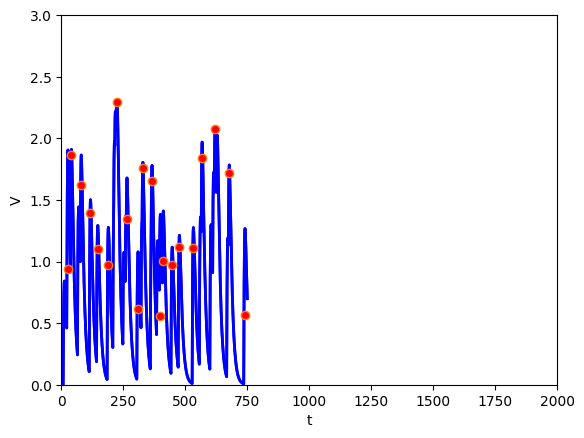

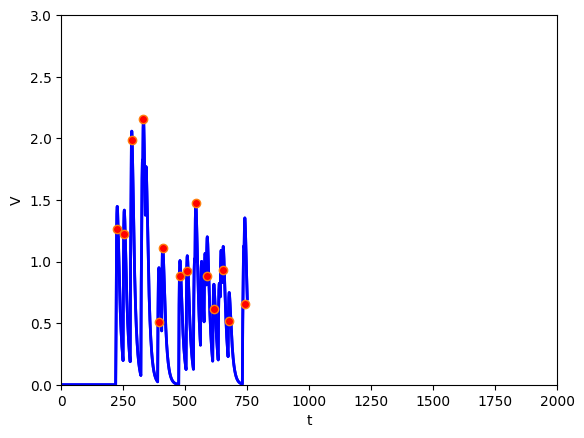

array([1.2602019 , 1.22111152, 1.98285996, 2.16004803, 0.51226078,
       1.10797201, 0.8842626 , 0.92116481, 1.47206453, 0.8793247 ,
       0.61416412, 0.9303267 , 0.52013959, 0.65754445])

In [ ]:
#just here for visualization of a sample parameter set's output
gen_spikes([250, 250, 0.1, 0], 2 , 0, 2) #gen_spikes([taudep, taufac, gl, Iapp], spk_dist, noise_magnitude, plotting_flag)
gen_spikes([600, 600, 0.1, 0], 2, 0, 2)


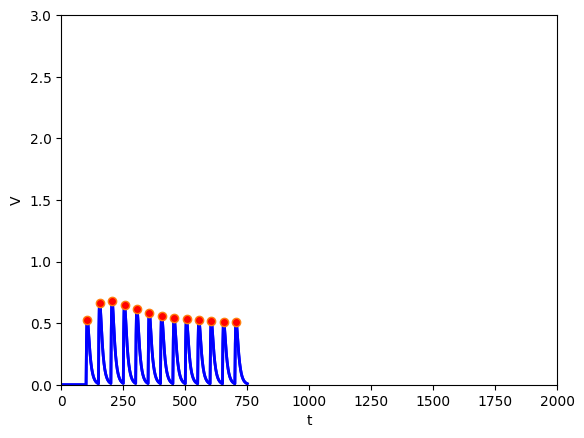

In [ ]:
#parameters of interest: taudep, taufac, gex, el, and later taudec

#p0 = taudec
#p1 = taufac
#p2 = Gl
#p3 = Iapp
low_bound_p0 = 10
up_bound_p0 = 750
low_bound_p1 = 10
up_bound_p1 = 750
low_bound_p2 = 0.001
up_bound_p2= 0.5
low_bound_p3 = -1
up_bound_p3 = 1



#Ground truth parameter set
tp0 = 400
tp1 = 100
tp2 = 0.1
tp3 = 0
true_params = [tp0, tp1, tp2, tp3]


#Here is where we get to decide exactly how we will define the statistics we use to measure the error between simulated and ground truth data. I have found training on the entire data set to be most effective, but the most computationally expensive as opposed to descriptive statistics of the dataset such as max amplitude, mean, and/or variance etc.


###Simplified summary statistics for future use

# def summary_stats(ts):
#   diff = gtd - ts
#   return  np.var(diff), st.kurtosis(diff)

##ordinal values for low(0), high(2), and band(1) filters
# def summary_stats(ts): #spike times, spike amplitudes
#     pks, pks_dict = signal.find_peaks(ts, prominence = [.1, None])
#     diff = gtd - ts
#     if(len(pks) == 0):
#       return 999, 999, 999
#     max_amp = max(pks_dict["prominences"])
#     toma = pks[np.where(pks_dict["prominences"] == max_amp)]#time of max amplitude
#     if(toma == pks[1]): ###low pass filter
#       return np.var(diff), st.kurtosis(diff), 0
#     elif(toma == pks[-1]): ###high pass filter
#       return np.var(diff), st.kurtosis(diff), 2
#     else:
#       return np.var(diff), st.kurtosis(diff), 1

#     return  np.var(diff), st.kurtosis(diff), max_amp, toma[0]


# def summary_stats(ts):
#   pks, pks_dict = signal.find_peaks(ts, prominence = [.1, None])
#   if(len(pks) < 3):
#     return 0, 0, 0, 0, 0, np.var(ts)
#   max_amp = max(pks_dict["prominences"])
#   toma = pks[np.where(pks_dict["prominences"] == max_amp)] #time of max amplitude
#   i = 0
#   while(ts[i] < .66*max_amp):
#     i += 1
#     if(i == len(ts)):
#       return pks_dict["prominences"][-1], max_amp, toma[0], t[-1], t[-1], np.var(ts)
#   j = int(toma/10)
#   #while(ts[j] > .66*max_amp):
#   j =0
#   flag = False
#   while(pks_dict["prominences"][j] < max_amp):
#     j += 1
#   while(pks_dict["prominences"][j] > 0.66*max_amp):
#     j += 1
#     if(j == len(pks_dict["prominences"])):
#       j-= 1
#       break;



  #return pks_dict["prominences"][-1], max_amp, toma[0], t[i], (pks[j] - toma[0])*dt, np.var(ts) #steady state amp, max amplitude, time of max amplitude, sigma fac, sigma dep


# def simulation_wrapper(params):
#   #return summary_stats(gen_spikes(params, 1, 0.000001, 0))
#   its = 50
#   out = np.zeros(len(gtd))
#   for i in range(0, its):
#     out += gen_spikes(params, 2, 0.00001, 0)
#   return out/its #gen_spikes(params, 0, 0.000001, 0)#gen_spikes(params, spkse, noise, fig):

def simulation_wrapper(params):
  return gen_spikes(params, 1, 0.000001, 0)


gtd = gen_spikes(true_params, 1, 0, 2)



In [ ]:
#ground truth visualization
# obs_ss = summary_stats(gtd)
obs_ss = simulation_wrapper(true_params)
#obs_ss = gen_spikes(true_params, 1, 0, 2)
#prior = utils.BoxUniform(low= torch.tensor([low_bound_p0]), high = torch.tensor([up_bound_p0]))
#prior = utils.BoxUniform(low= torch.tensor([low_bound_p0, low_bound_p1]), high = torch.tensor([up_bound_p0, up_bound_p1]))
prior = utils.BoxUniform(low= torch.tensor([low_bound_p0,low_bound_p1,low_bound_p2,low_bound_p3]), high = torch.tensor([up_bound_p0,up_bound_p1, up_bound_p2,up_bound_p3]))

In [ ]:
obs_ss

array([ 0.        , -0.00014718, -0.00036783, ...,  0.0026849 ,
        0.00304877,  0.00320932])

In [ ]:
sims = 1000
posterior = infer(simulation_wrapper, prior, method= "SNPE", num_simulations=sims)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 37 epochs.

In [ ]:
samples = posterior.sample((1000,), x = obs_ss)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

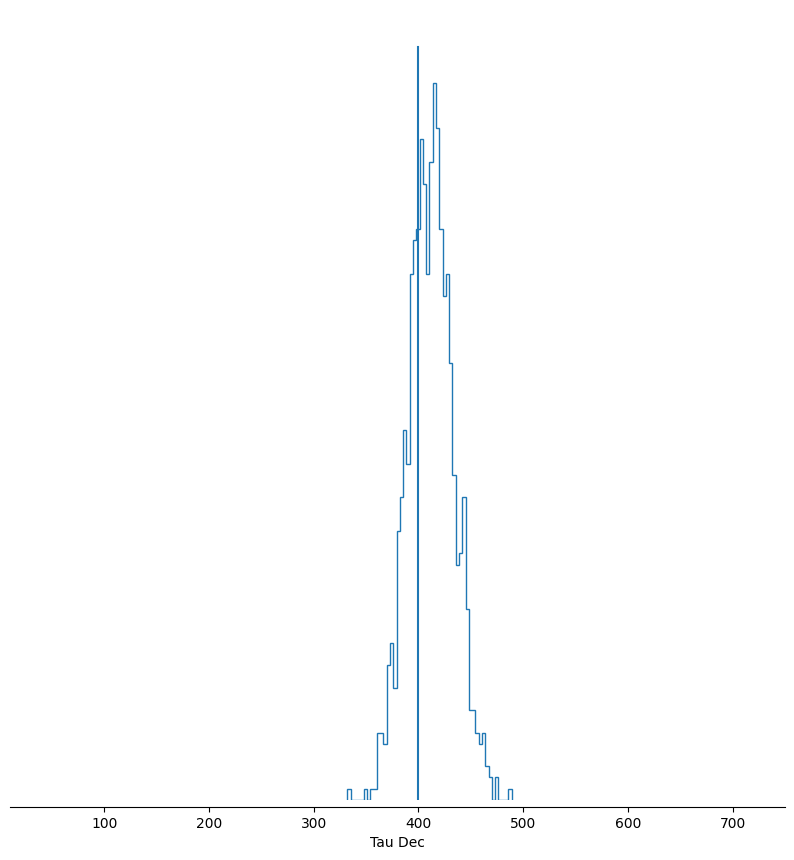

In [ ]:
log_probability = posterior.log_prob(samples, x = obs_ss)
#_ = analysis.pairplot(samples, limits = [ [low_bound_p0, up_bound_p0]], labels = ["Tau Dec"] , points = [true_params], points_color = '-r')
#_ = analysis.pairplot(samples, limits = [ [low_bound_p0, up_bound_p0], [low_bound_p1, up_bound_p1]], labels = ["Gl", "Iapp"] , points = [true_params], points_color = '-r')
_ = analysis.pairplot(samples, limits = [ [low_bound_p0, up_bound_p0], [low_bound_p1, up_bound_p1], [low_bound_p2, up_bound_p2], [low_bound_p3, up_bound_p3]], labels = ["Tau Dep", "Tau Fac", "Gl", "Iapp"] , points = [true_params], points_color = '-r')

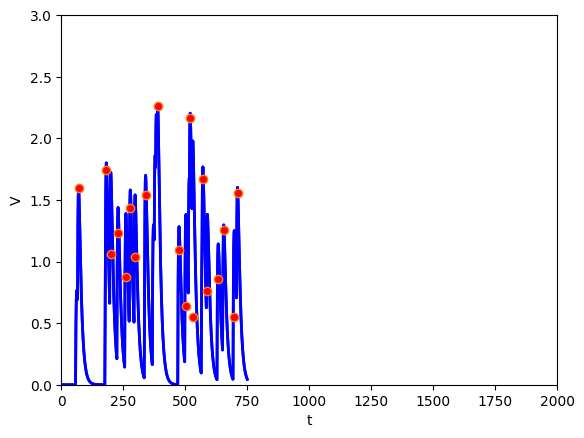

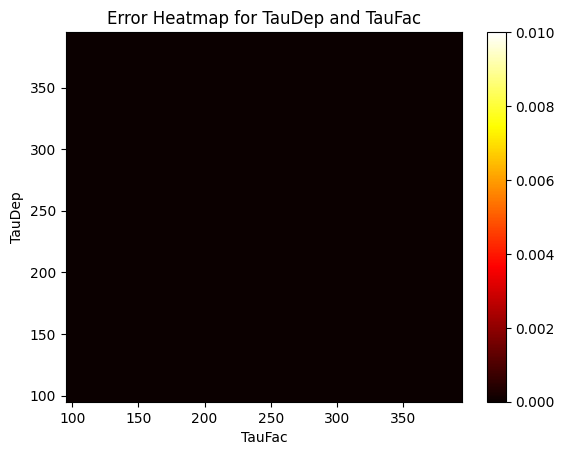

In [ ]:
#Error heatmap in TauDep, TauFac space

gtd = gen_spikes([250, 250, 0.1, 0], 0, 0, 2)
param_range = np.arange(100, 400, 10)
#param_range = np.arange(0, 1, .2)
err_arr = np.zeros((len(param_range), len(param_range)))

def rmse(arr):
  return (np.var(np.diff(arr)) - np.var(np.diff(gtd)))**2
  #return  np.mean([math.sqrt(np.mean(arr - gtd)**2), np.mean(np.sqrt((arr - gtd)**2)), math.sqrt((sum((arr - gtd)**3)/(len(arr) - 1)/ np.mean(np.sqrt((arr - gtd)**2))**3)**2)])
  #return np.mean([abs(np.mean(aux)), abs(np.var(aux)), abs(st.skew(aux)), abs(st.kurtosis(aux))])

for i, td in enumerate(param_range):
  for j, tf in enumerate(param_range):
    err_arr[i, j] = rmse(gen_spikes([td, tf, 0.1, 0], 0, 0, 0))
    #err_arr[i, j] = rmse(gen_spikes([250, 250, td, tf], 1, 0, 0))

fig = plt.figure()
plt.title("Error Heatmap for TauDep and TauFac")
sc = plt.pcolormesh(param_range, param_range, err_arr, cmap = 'hot', vmax = 0.01)
plt.xlabel('TauFac')
plt.ylabel('TauDep')
cbar = fig.colorbar(sc)
plt.show()


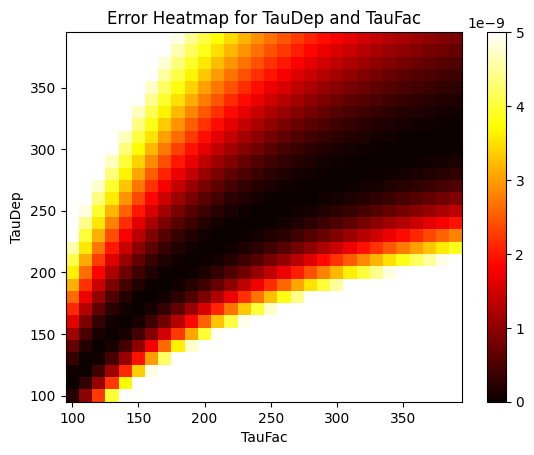

In [ ]:
fig = plt.figure()
plt.title("Error Heatmap for TauDep and TauFac")
sc = plt.pcolormesh(param_range, param_range, err_arr, cmap = 'hot', vmax = .000000005)
plt.xlabel('TauFac')
plt.ylabel('TauDep')
cbar = fig.colorbar(sc)
plt.show()


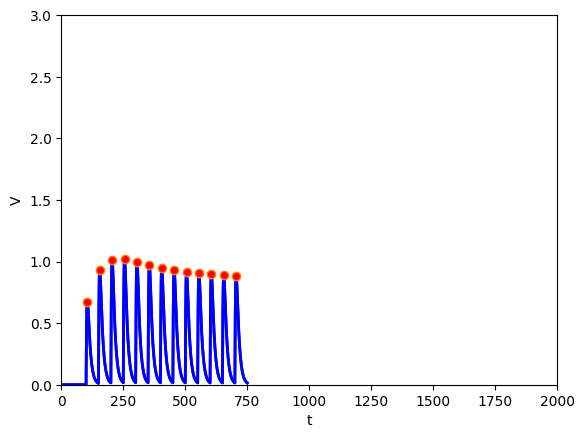

NameError: ignored

In [ ]:
#Error heatmap in Gl, Iapp space
gtd = gen_spikes([400, 200, 0.1, 0], 0, 0, 2)
param_range1 = np.linspace(0.05, 0.15, 50)
param_range2 = np.linspace(-0.1, 0.1, 50)
err_arr = np.zeros((len(param_range1), len(param_range2)))

# def rmse(arr):
#   return  np.mean(np.sqrt((arr - gtd)**2))

for i, td in enumerate(param_range1):
  for j, tf in enumerate(param_range2):
    err_arr[i, j] = rmse(gen_spikes([400, 200, td, tf], 0, 0, 0))

fig = plt.figure()
sc = plt.pcolormesh(param_range2, param_range1, err_arr, cmap = 'hot', vmax = 3)
plt.title("Error Heatmap for Gl and Iapp")
plt.xlabel("Iapp")
plt.ylabel("Gl")
cbar = fig.colorbar(sc)
plt.show()

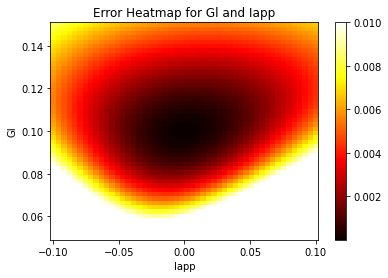

In [ ]:
fig = plt.figure()
sc = plt.pcolormesh(param_range2, param_range1, err_arr, cmap = 'hot', vmax = 0.01)
plt.title("Error Heatmap for Gl and Iapp")
plt.xlabel("Iapp")
plt.ylabel("Gl")
cbar = fig.colorbar(sc)
plt.show()

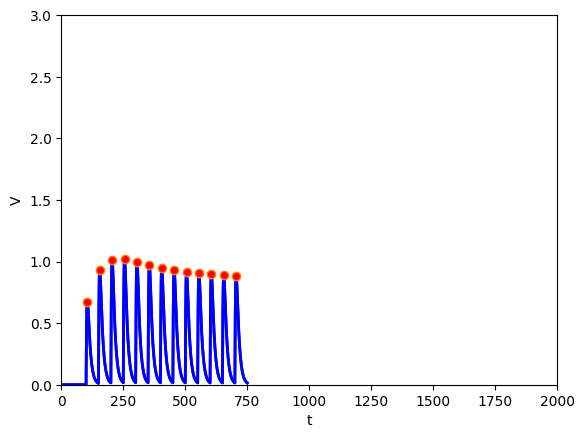

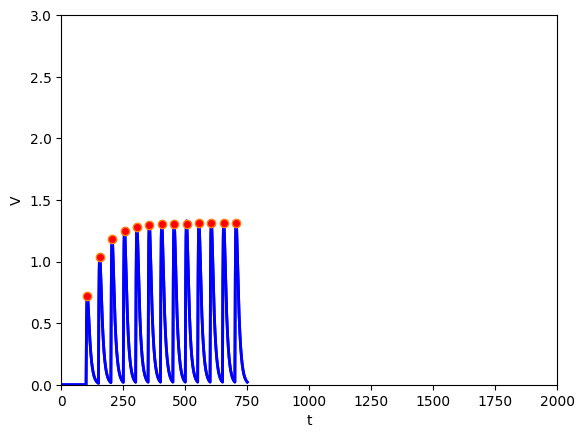

1.310942280149085
[1051 1551 2051 2551 3051 3551 4051 4551 5051 5551 6051 6551 7051]
7051


(0.01279756019829071, 0.9822045914423141, 1.310942280149085, array([7051]))

In [ ]:
gtd = gen_spikes([400, 200, 0.1, 0], 1, 0, 2)
test = gen_spikes([250, 250, 0.1, 0], 1, 0, 2)
def summary_stats(ts): #spike times, spike amplitudes
    pks, pks_dict = signal.find_peaks(ts, prominence = [.1, None])
    # print("Length of array 1: " + str(len(pks_dict["prominences"])))
    # print(pks_dict["prominences"])
    # print("\nLength of array 2: " + str(len(pks)))
    # print(pks)
    diff = gtd - ts
    print(max(pks_dict["prominences"]))
    max_amp = max(pks_dict["prominences"])
    toma = pks[np.where(pks_dict["prominences"] == max_amp)]#time of max amplitude

    return  np.var(diff), st.kurtosis(diff), max_amp, toma[0]


summary_stats(test)

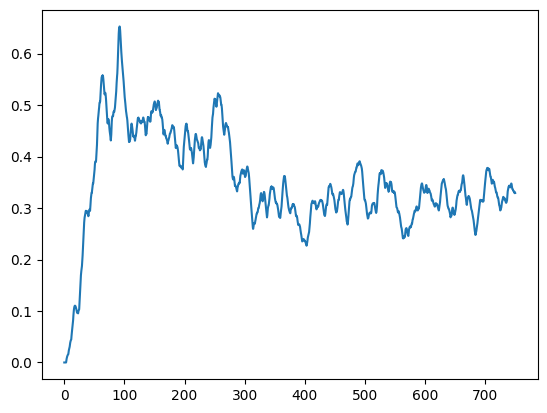

In [ ]:
#Averaging of poisson trials
its = 50
x = np.zeros(len(t))

for i in range(0, its):
  #print(i)
  x += gen_spikes([400, 100, 0.1, 0], 2, 0, 0)

x = x/its
f = plt.figure()
plt.plot(t, x)



Text(0, 0.5, 'Voltage (mV)')

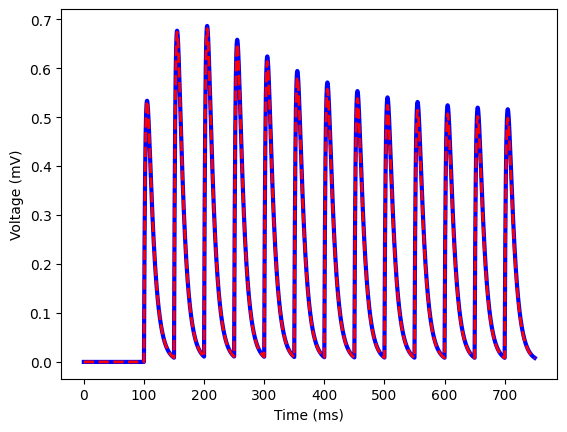

In [ ]:
#superposed parameter sets
x = gen_spikes([400, 100, 0.1, 0], 1, 0, 0)
y = gen_spikes([425, 100, 0.1, 0], 1, 0, 0)

f = plt.figure()

plt.plot(t, x, '-b', linewidth = 3)
plt.plot(t, y, '--r', linewidth = 2)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

